In [2]:
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
import json
warnings.filterwarnings('ignore')

with open("config.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgres+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [3]:
#declare all repo ids you would like to produce charts for
repo_set = {25440, 25448}

#can be set as 'competitors' or 'repo'
#'competitors' will group graphs by type, so it is easy to compare across repos
# 'repo' will group graphs by repo so it is easy to look at all the contributor data for each repo
display_grouping = 'repo'

#if display_grouping is set to 'competitors', enter the repo ids you do no want to alias, if 'display_grouping' is set to repo the list will not effect anything
not_aliased_repos = [25440, 25448]

#group_by can be set as 'month' or 'year'
group_by = 'month'

#requirements for a contributor to be considered a repeat contributor
time = 365
num_contributions_required = 5

#specify dates for filtering
#if the end_date is in the future, the end_date will default to the current_date
begin_date = '2019-10-01'
end_date = '2020-10-31'

save_files = False

In [4]:
#create tuple that contains all the contributor rankings needed
rank_list = []
for num in range(1, num_contributions_required + 1):
    rank_list.append(num)
rank_tuple = tuple(rank_list)

In [5]:
df = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""        
    

    SELECT * FROM (
        SELECT ID AS
            cntrb_id,
            A.created_at AS created_at,
            date_part('month', A.created_at::DATE) AS month,
            date_part('year', A.created_at::DATE) AS year,
            A.repo_id,
            repo_name,
            full_name,
            login,
        ACTION,
        rank() OVER (
                PARTITION BY id
                ORDER BY A.created_at ASC
            )
        FROM
            (
                (
                SELECT
                    canonical_id AS ID,
                    created_at AS created_at,
                    repo_id,
                    'issue_opened' AS ACTION,
                    contributors.cntrb_full_name AS full_name,
                    contributors.cntrb_login AS login 
                FROM
                    augur_data.issues
                    LEFT OUTER JOIN augur_data.contributors ON contributors.cntrb_id = issues.reporter_id
                    LEFT OUTER JOIN ( SELECT DISTINCT ON ( cntrb_canonical ) cntrb_full_name, cntrb_canonical AS canonical_email, data_collection_date, cntrb_id AS canonical_id 
                    FROM augur_data.contributors WHERE cntrb_canonical = cntrb_email ORDER BY cntrb_canonical 
                    ) canonical_full_names ON canonical_full_names.canonical_email = contributors.cntrb_canonical 
                WHERE
                    repo_id = {repo_id}
                    AND pull_request IS NULL 
                GROUP BY
                    canonical_id,
                    repo_id,
                    issues.created_at,
                    contributors.cntrb_full_name,
                    contributors.cntrb_login 
                ) UNION ALL
                (
                SELECT
                    canonical_id AS ID,
                    TO_TIMESTAMP( cmt_author_date, 'YYYY-MM-DD' ) AS created_at,
                    repo_id,
                    'commit' AS ACTION,
                    contributors.cntrb_full_name AS full_name,
                    contributors.cntrb_login AS login 
                FROM
                    augur_data.commits
                    LEFT OUTER JOIN augur_data.contributors ON cntrb_email = cmt_author_email
                    LEFT OUTER JOIN ( SELECT DISTINCT ON ( cntrb_canonical ) cntrb_full_name, cntrb_canonical AS canonical_email, data_collection_date, cntrb_id AS canonical_id 
                    FROM augur_data.contributors WHERE cntrb_canonical = cntrb_email ORDER BY cntrb_canonical 
                    ) canonical_full_names ON canonical_full_names.canonical_email = contributors.cntrb_canonical 
                WHERE
                    repo_id = {repo_id} 
                GROUP BY
                    repo_id,
                    canonical_email,
                    canonical_id,
                    commits.cmt_author_date,
                    contributors.cntrb_full_name,
                    contributors.cntrb_login 
                ) UNION ALL
                (
                SELECT
                    message.cntrb_id AS ID,
                    created_at AS created_at,
                    commits.repo_id,
                    'commit_comment' AS ACTION,
                    contributors.cntrb_full_name AS full_name,
                    contributors.cntrb_login AS login
      
                FROM
                    augur_data.commit_comment_ref,
                    augur_data.commits,
                    augur_data.message
                    LEFT OUTER JOIN augur_data.contributors ON contributors.cntrb_id = message.cntrb_id
                    LEFT OUTER JOIN ( SELECT DISTINCT ON ( cntrb_canonical ) cntrb_full_name, cntrb_canonical AS canonical_email, data_collection_date, cntrb_id AS canonical_id 
                    FROM augur_data.contributors WHERE cntrb_canonical = cntrb_email ORDER BY cntrb_canonical 
                    ) canonical_full_names ON canonical_full_names.canonical_email = contributors.cntrb_canonical 
                WHERE
                    commits.cmt_id = commit_comment_ref.cmt_id 
                    AND commits.repo_id = {repo_id} 
                    AND commit_comment_ref.msg_id = message.msg_id
 
                GROUP BY
                    ID,
                    commits.repo_id,
                    commit_comment_ref.created_at,
                    contributors.cntrb_full_name,
                    contributors.cntrb_login
                ) UNION ALL
                (
                SELECT
                    issue_events.cntrb_id AS ID,
                    issue_events.created_at AS created_at,
                    repo_id,
                    'issue_closed' AS ACTION,
                    contributors.cntrb_full_name AS full_name,
                    contributors.cntrb_login AS login 
                FROM
                    augur_data.issues,
                    augur_data.issue_events
                    LEFT OUTER JOIN augur_data.contributors ON contributors.cntrb_id = issue_events.cntrb_id
                    LEFT OUTER JOIN ( SELECT DISTINCT ON ( cntrb_canonical ) cntrb_full_name, cntrb_canonical AS canonical_email, data_collection_date, cntrb_id AS canonical_id 
                    FROM augur_data.contributors WHERE cntrb_canonical = cntrb_email ORDER BY cntrb_canonical 
                    ) canonical_full_names ON canonical_full_names.canonical_email = contributors.cntrb_canonical 
                WHERE
                    issues.repo_id = {repo_id} 
                    AND issues.issue_id = issue_events.issue_id 
                    AND issues.pull_request IS NULL 
                    AND issue_events.cntrb_id IS NOT NULL 
                    AND ACTION = 'closed' 
                GROUP BY
                    issue_events.cntrb_id,
                    repo_id,
                    issue_events.created_at,
                    contributors.cntrb_full_name,
                    contributors.cntrb_login 
                ) UNION ALL
                (
                SELECT
                    pr_augur_contributor_id AS ID,
                    pr_created_at AS created_at,
                    repo_id,
                    'open_pull_request' AS ACTION,
                    contributors.cntrb_full_name AS full_name,
                    contributors.cntrb_login AS login 
                FROM
                    augur_data.pull_requests
                    LEFT OUTER JOIN augur_data.contributors ON pull_requests.pr_augur_contributor_id = contributors.cntrb_id
                    LEFT OUTER JOIN ( SELECT DISTINCT ON ( cntrb_canonical ) cntrb_full_name, cntrb_canonical AS canonical_email, data_collection_date, cntrb_id AS canonical_id 
                    FROM augur_data.contributors WHERE cntrb_canonical = cntrb_email ORDER BY cntrb_canonical 
                    ) canonical_full_names ON canonical_full_names.canonical_email = contributors.cntrb_canonical 
                WHERE
                    pull_requests.repo_id = {repo_id} 
                GROUP BY
                    pull_requests.pr_augur_contributor_id,
                    pull_requests.repo_id,
                    pull_requests.pr_created_at,
                    contributors.cntrb_full_name,
                    contributors.cntrb_login 
                ) UNION ALL
                (
                SELECT
                    message.cntrb_id AS ID,
                    msg_timestamp AS created_at,
                    repo_id,
                    'pull_request_comment' AS ACTION,
                    contributors.cntrb_full_name AS full_name,
                    contributors.cntrb_login AS login 
                FROM
                    augur_data.pull_requests,
                    augur_data.pull_request_message_ref,
                    augur_data.message
                    LEFT OUTER JOIN augur_data.contributors ON contributors.cntrb_id = message.cntrb_id
                    LEFT OUTER JOIN ( SELECT DISTINCT ON ( cntrb_canonical ) cntrb_full_name, cntrb_canonical AS canonical_email, data_collection_date, cntrb_id AS canonical_id 
                    FROM augur_data.contributors WHERE cntrb_canonical = cntrb_email ORDER BY cntrb_canonical 
                    ) canonical_full_names ON canonical_full_names.canonical_email = contributors.cntrb_canonical 
                WHERE
                    pull_requests.repo_id = {repo_id}
                    AND pull_request_message_ref.pull_request_id = pull_requests.pull_request_id 
                    AND pull_request_message_ref.msg_id = message.msg_id 
                GROUP BY
                    message.cntrb_id,
                    pull_requests.repo_id,
                    message.msg_timestamp,
                    contributors.cntrb_full_name,
                    contributors.cntrb_login 
                ) UNION ALL
                (
                SELECT
                    issues.reporter_id AS ID,
                    msg_timestamp AS created_at,
                    repo_id,
                    'issue_comment' AS ACTION,
                    contributors.cntrb_full_name AS full_name,
                    contributors.cntrb_login AS login 
                FROM
                    issues,
                    issue_message_ref,
                    message
                    LEFT OUTER JOIN augur_data.contributors ON contributors.cntrb_id = message.cntrb_id
                    LEFT OUTER JOIN ( SELECT DISTINCT ON ( cntrb_canonical ) cntrb_full_name, cntrb_canonical AS canonical_email, data_collection_date, cntrb_id AS canonical_id 
                    FROM augur_data.contributors WHERE cntrb_canonical = cntrb_email ORDER BY cntrb_canonical 
                    ) canonical_full_names ON canonical_full_names.canonical_email = contributors.cntrb_canonical 
                WHERE
                    issues.repo_id = {repo_id}
                    AND issue_message_ref.msg_id = message.msg_id 
                    AND issues.issue_id = issue_message_ref.issue_id
                    AND issues.pull_request_id = NULL
                GROUP BY
                    issues.reporter_id,
                    issues.repo_id,
                    message.msg_timestamp,
                    contributors.cntrb_full_name,
                    contributors.cntrb_login 
                ) 
            ) A,
            repo 
        WHERE
        ID IS NOT NULL 
            AND A.repo_id = repo.repo_id 
        GROUP BY
            A.ID,
            A.repo_id,
            A.ACTION,
            A.created_at,
            repo.repo_name,
            A.full_name,
            A.login
        ORDER BY 
            cntrb_id
        ) b
        WHERE RANK IN {rank_tuple}

""")
    df_first_repo = pd.read_sql(pr_query, con=engine)
    if not df.empty: 
        df = pd.concat([df, df_first_repo]) 
    else: 
        # first repo
        df = df_first_repo
        
display(df)

,cntrb_id,created_at,month,year,repo_id,repo_name,full_name,login,action,rank
0,277117,2019-10-09 09:24:15+02:00,10.0,2019.0,25440,augur,None,None,open_pull_request,1
1,277123,2020-03-28 20:26:36+01:00,3.0,2020.0,25440,augur,None,mbbroberg,open_pull_request,1
2,277123,2020-03-31 15:33:07+02:00,3.0,2020.0,25440,augur,None,mbbroberg,pull_request_comment,2
3,277123,2020-03-31 15:35:38+02:00,3.0,2020.0,25440,augur,None,mbbroberg,pull_request_comment,3
4,277134,2017-02-15 15:38:45+01:00,2.0,2017.0,25440,augur,None,None,open_pull_request,1
...,...,...,...,...,...,...,...,...,...,...
256,280693,2020-11-09 09:56:01+01:00,11.0,2020.0,25448,grimoirelab,None,ZHANG-SHINE,issue_closed,1
257,280819,2021-01-11 14:26:35+01:00,1.0,2021.0,25448,grimoirelab,None,Nolski,open_pull_request,1
258,280819,2021-01-11 14:28:45+01:00,1.0,2021.0,25448,grimoirelab,None,Nolski,open_pull_request,2
259,282155,2021-01-14 22:24:08+01:00,1.0,2021.0,25448,grimoirelab,None,hmitsch,open_pull_request,1


## Top 10 contributors

login
GeorgLink            17
gabe-heim            15
abhinavbajpai2012    13
dependabot[bot]      13
ccarterlandis        11
Nebrethar            10
sduenas              10
jgbarah              10
ivanayov             10
pratikmishra356      10
dtype: int64


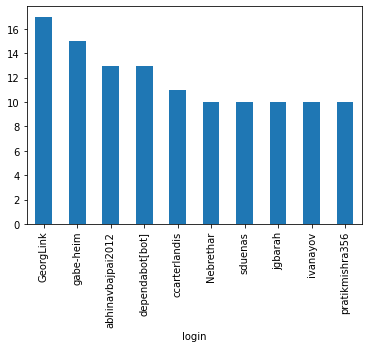

In [6]:
gk = df.groupby('login')
size_df = gk.size().sort_values(ascending=False) 

THRESHOLD = 10

subset = size_df[:THRESHOLD]
#size_df.head()
print(subset)


#size_df.sort_values(axis=1)

subset.plot.bar()